# `STARSKØPE`



**Building a Cyberoptic Neural Network Telescope for Astrophysical Object Classification**

> Flatiron School Capstone Project
* `Ru Keïn`
* `Instructor: James Irving PhD`
* `Data Science Full-Time Program`
* `Blog post URL:`
* `Non-Technical Presentation`:

    Note: this project is divided into 3 notebooks:

    starskøpe I : Keras Neural Network Model (this notebook)
    starskøpe II: Computer Vision/Restricted Boltzmann Machines for Spectographs
    starskøpe III: CV/RBMs for Fourier Transformed Spectographs

# Mission Brief

## ABSTRACT

**Questions**
Can a transiting exoplanet be detected strictly by analyzing the raw flux values of a given star? What kind of normalization, de-noising, and/or unit conversion is necessary in order for the analysis to be accurate? How much signal-to-noise ratio is too much? That is, if the classes are highly imbalanced, for instance only a few planets can be confirmed out of thousands of stars, does the imbalance make for an unreliable machine learning model?

**MODEL 1**
To answer the above questions, I started the analysis with a labeled timeseries dataset from Kaggle posted by NASA for K2's campaign 3 observations in which only 42 confirmed exoplanets are detected in a set of over 5,000 stars. This data is labeled and therefore primed for machine learning, however it has no units, and while it is a timeseries, the actual timestamps are not included. If we compare this to the type of data available on the MAST website where the original K2 data and other space telescope observations are housed, there is a significant amount of information about the target stars that is missing and typically quite useful in terms of modeling and analysis for the purpose of detecting exoplanets. 

    [] Results of analysis I

    [] Part 2: can the model be improved using computer vision (spectographs)

    [] Results of analysis II

    [] Part 3: can the model be improved using CV on fourier transformed specs?

    [] Results of part III

    [] conclusion and summary

    [] mention of future work

    [] link to dashboard/blog



# Obtain

Begin by importing libraries and code packages for basic analysis, as well as the kaggle dataset.

In [1]:
# Import code packages and libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
%matplotlib inline
from matplotlib.colors import LogNorm

import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')
 

font_dict={'family':'"Titillium Web", monospace','size':16}
mpl.rc('font',**font_dict)


#ignore pink warnings
import warnings
warnings.filterwarnings('ignore')
# Allow for large # columns
pd.set_option('display.max_columns', 0)
# pd.set_option('display.max_rows','')

Import dataset which has already been split into train and test sets, `exoTrain.csv.zip` and `exoTest.csv.zip` (I compressed them from their original csv format since the training set is > 240 MB so we'll to unzip them).

In [2]:
import os, glob, sys

home = os.path.abspath(os.curdir)

os.listdir(home)

['sparknotes.txt',
 '.DS_Store',
 'LICENSE',
 'Icon\r',
 'spec',
 'sklearn-sparknotes.ipynb',
 'starskøpe-2.ipynb',
 'models',
 'todo.md',
 'README.md',
 '.gitignore',
 'starskøpe.ipynb',
 '_config.yml',
 '.ipynb_checkpoints',
 'DONT_PANIC',
 '.git',
 'data',
 'assets',
 'notebooks',
 'pyFunc']

In [3]:
# %cd ../
%cd data
%ls

/Users/hakkeray/CODE/DATASCIENCE/BOOTCAMP/CAPSTONE/starskope/data
Icon?                                 exoTest.csv.zip
__MACOSX/                             exoTrain.csv
cumulative.csv                        exoTrain.csv.zip
emissionspec_2020.01.30_19.43.11.csv  oec.csv
exoTableDraw.R                        transitspec_2020.01.30_19.38.06.csv
exoTest.csv


In [4]:
# uncomment below if you need to unzip the data files
# !unzip -q 'exoTrain.csv.zip'
# !unzip -q 'exoTest.csv.zip'
# %ls

In [5]:
train = pd.read_csv('exoTrain.csv')
test = pd.read_csv('exoTest.csv')

In [6]:
# cd backto home / root directory
%cd ../

/Users/hakkeray/CODE/DATASCIENCE/BOOTCAMP/CAPSTONE/starskope


# Scrub

In [7]:
display(train.head(), test.head())

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,FLUX.11,FLUX.12,FLUX.13,FLUX.14,FLUX.15,FLUX.16,FLUX.17,FLUX.18,FLUX.19,FLUX.20,FLUX.21,FLUX.22,FLUX.23,FLUX.24,FLUX.25,FLUX.26,FLUX.27,FLUX.28,FLUX.29,FLUX.30,FLUX.31,FLUX.32,FLUX.33,FLUX.34,FLUX.35,FLUX.36,FLUX.37,FLUX.38,FLUX.39,FLUX.40,FLUX.41,...,FLUX.3156,FLUX.3157,FLUX.3158,FLUX.3159,FLUX.3160,FLUX.3161,FLUX.3162,FLUX.3163,FLUX.3164,FLUX.3165,FLUX.3166,FLUX.3167,FLUX.3168,FLUX.3169,FLUX.3170,FLUX.3171,FLUX.3172,FLUX.3173,FLUX.3174,FLUX.3175,FLUX.3176,FLUX.3177,FLUX.3178,FLUX.3179,FLUX.3180,FLUX.3181,FLUX.3182,FLUX.3183,FLUX.3184,FLUX.3185,FLUX.3186,FLUX.3187,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,-160.17,-207.47,-154.88,-173.71,-146.56,-120.26,-102.85,-98.71,-48.42,-86.57,-0.84,-25.85,-67.39,-36.55,-87.01,-97.72,-131.59,-134.80,-186.97,-244.32,-225.76,-229.60,-253.48,-145.74,-145.74,30.47,-173.39,-187.56,-192.88,-182.76,-195.99,-208.31,...,-367.84,-317.51,-167.69,-56.86,7.56,37.40,-81.13,-20.10,-30.34,-320.48,-320.48,-287.72,-351.25,-70.07,-194.34,-106.47,-14.80,63.13,130.03,76.43,131.90,-193.16,-193.16,-89.26,-17.56,-17.31,125.62,68.87,100.01,-9.60,-25.39,-16.51,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,-73.38,-86.51,-74.97,-73.15,-86.13,-76.57,-61.27,-37.23,-48.53,-30.96,-8.14,-5.54,15.79,45.71,10.61,40.66,16.70,15.18,11.98,-203.70,19.13,19.13,19.13,19.13,19.13,17.02,-8.50,-13.87,-29.10,-34.29,-24.68,-27.62,...,-51.99,-32.14,-36.75,-15.49,-13.24,20.46,-1.47,-0.40,27.80,-58.20,-58.20,-72.04,-58.01,-30.92,-13.42,-13.98,-5.43,8.71,1.80,36.59,-9.80,-19.53,-19.53,-24.32,-23.88,-33.07,-9.03,3.75,11.61,-12.66,-5.69,12.53,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,484.39,469.66,462.30,492.23,441.20,483.17,481.28,535.31,554.34,562.80,540.14,576.34,551.67,556.69,550.86,577.33,562.08,577.97,530.67,553.27,538.33,527.17,532.50,273.66,273.66,292.39,298.44,252.64,233.58,171.41,224.02,237.69,...,-106.97,-56.38,-51.09,-33.30,-61.53,-89.61,-69.17,-86.47,-140.91,-84.20,-84.20,-89.09,-55.44,-61.05,-29.17,-63.80,-57.61,2.70,-31.25,-47.09,-6.53,14.00,14.00,-25.05,-34.98,-32.08,-17.06,-27.77,7.86,-70.77,-64.44,-83.83,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,323.33,311.14,326.19,313.11,313.89,317.96,330.92,341.10,360.58,370.29,369.71,339.00,336.24,319.31,321.56,308.02,296.82,279.34,275.78,289.67,281.33,285.37,281.87,88.75,88.75,67.71,74.46,69.34,76.51,80.26,70.31,63.67,...,-30.46,-32.40,-2.75,14.29,-14.18,-25.14,-13.43,-14.74,2.24,-31.07,-31.07,-50.27,-39.22,-51.33,-18.53,-1.99,10.43,-1.97,-15.32,-23.38,-27.71,-36.12,-36.12,-15.65,6.63,10.66,-8.57,-8.29,-21.90,-25.80,-29.86,7.42,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,-970.88,-933.30,-889.49,-888.66,-853.95,-800.91,-754.48,-717.24,-649.34,-605.71,-575.62,-526.37,-490.12,-458.73,-447.76,-419.54,-410.76,-404.10,-425.38,-397.29,-412.73,-446.49,-413.46,-1006.21,-1006.21,-973.29,-986.01,-975.88,-982.20,-953.73,-964.35,-956.60,...,-848.88,-732.66,-694.76,-705.01,-625.24,-604.16,-668.26,-742.18,-820.55,-874.76,-874.76,-853.68,-808.62,-777.88,-712.62,-694.01,-655.74,-599.74,-617.30,-602.98,-539.29,-672.71,-672.71,-594.49,-597.60,-560.77,-501.95,-461.62,-468.59,-513.24,-504.70,-521.95,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,FLUX.11,FLUX.12,FLUX.13,FLUX.14,FLUX.15,FLUX.16,FLUX.17,FLUX.18,FLUX.19,FLUX.20,FLUX.21,FLUX.22,FLUX.23,FLUX.24,FLUX.25,FLUX.26,FLUX.27,FLUX.28,FLUX.29,FLUX.30,FLUX.31,FLUX.32,FLUX.33,FLUX.34,FLUX.35,FLUX.36,FLUX.37,FLUX.38,FLUX.39,FLUX.40,FLUX.41,...,FLUX.3156,FLUX.3157,FLUX.3158,FLUX.3159,FLUX.3160,FLUX.3161,FLUX.3162,FLUX.3163,FLUX.3164,FLUX.3165,FLUX.3166,FLUX.3167,FLUX.3168,FLUX.3169,FLUX.3170,FLUX.3171,FLUX.3172,FLUX.3173,FLUX.3174,FLUX.3175,FLUX.3176,FLUX.3177,FLUX.3178,FLUX.3179,FLUX.3180,FLUX.3181,FLUX.3182,FLUX.3183,FLUX.3184,FLUX.3185,FLUX.3186,FLUX.3187,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,119.88,100.21,86.46,48.68,46.12,39.39,18.57,6.98,6.63,-21.97,-23.17,-29.26,-33.99,-6.25,-28.12,-27.24,-32.28,-12.29,-16.57,-23.86,-5.69,9.24,35.52,81.20,116.49,133.99,148.97,174.15,187.77,215.30,246.80,-56.68,-56.68,-56.68,-52.05,-31.52,-31.15,-48.53,-38.93,-26.06,6.63,...,3.45,6.49,-2.55,12.26,-7.06,-23.53,2.54,30.21,38.87,-22.86,-22.86,-4.37,2.27,-16.27,-30.84,-7.21,-4.27,13.60,15.62,31.96,49.89,86.93,86.93,42.99,48.76,22.82,32.79,30.76,14.55,10.92,22.68,5.91,14.52,19.29,14.44,-1.62,13.33,45.50,31.93,35.78,269.43,57.72
1,2,5736.59,5699.98,5717.16,5692.73,5663.83,5631.16,5626.39,5569.47,5550.44,5458.80,5329.39,5191.38,5031.39,4769.89,4419.66,4218.92,3924.73,3605.30,3326.55,3021.20,2800.61,2474.48,2258.33,1951.69,1749.86,1585.38,1575.48,1568.41,1661.08,1977.33,2425.62,2889.61,3847.64,3847.64,3741.20,3453.47,3202.61,2923.73,2694.84,2474.22,2195.09,...,574.19,-216.31,-3470.75,-4510.72,-5013.41,-3636.05,-2324.27,-2688.55,-2813.66,-586.22,-586.22,-756.80,-1090.23,-1388.61,-1745.36,-2015.28,-2359.06,-2516.66,-2699.31,-2777.55,-2732.97,1167.39,1167.39,1368.89,1434.80,1360.75,1148.44,1117.67,714.86,419.02,57.06,-175.66,-581.91,-984.09,-1230.89,-1600.45,-1824.53,-2061.17,-2265.98,-2366.19,-2294.86,-2034.72
2,2,844.48,817.49,770.07,675.01,605.52,499.45,440.77,362.95,207.27,150.46,85.49,-20.12,-35.88,-65.59,-15.12,16.60,-25.70,61.88,53.18,64.32,72.38,100.35,67.26,14.71,-16.41,-147.46,-231.27,-320.29,-407.82,-450.48,-146.99,-146.99,-146.99,-146.99,-166.30,-139.90,-96.41,-23.49,13.59,67.59,32.09,...,-112.96,-129.34,-35.24,-70.13,-35.30,-56.48,-74.60,-115.18,-8.91,-37.59,-37.59,-37.43,-104.23,-101.45,-107.35,-109.82,-126.27,-170.32,-117.85,-32.30,-70.18,314.29,314.29,314.29,149.71,54.60,12.60,-133.68,-78.16,-52.30,-8.55,-19.73,17.82,-51.66,-48.29,-59.99,-82.10,-174.54,-95.23,-162.68,-36.79,30.63
3,2,-826.00,-827.31,-846.12,-836.03,-745.50,-784.69,-791.22,-746.50,-709.53,-679.56,-706.03,-720.56,-631.12,-659.16,-672.03,-665.06,-667.94,-660.84,-672.75,-644.91,-680.53,-620.50,-570.34,-530.00,-537.88,-578.38,-532.34,-532.38,-491.03,-485.03,-427.19,-380.84,-329.50,-286.91,-283.81,-298.19,-271.03,-268.50,-209.56,-180.44,-136.25,...,81.06,110.88,16.50,-1286.59,-1286.59,-1286.59,-1286.59,-1286.59,-1286.59,-1286.59,-1286.59,-14.94,64.09,8.38,45.31,100.72,91.53,46.69,20.34,30.94,-36.81,-33.28,-69.62,-208.00,-280.28,-340.41,-337.41,-268.03,-245.00,-230.62,-129.59,-35.47,122.34,93.03,93.03,68.81,9.81,20.75,20.25,-120.81,-257.56,-215.41
4,2,-39.57,-15.88,-9.16,-6.37,-16.13,-24.05,-0.90,-45.20,-5.04,14.62,-19.52,-11.43,-49.80,25.84,11.62,3.18,-9.59,14.49,8.82,32.32,-28.90,-28.90,-14.09,-30.87,-18.99,-38.60,-27.79,9.65,29.60,7.88,42.87,27.59,27.05,20.26,29.48,9.71,22.84,25.99,-667.55,-1336.24,-1207.88,...,-203.96,-171.62,-122.12,-32.01,-47.15,-56.45,-41.71,-34.13,-43.12,-53.63,-53.63,-53.63,-24.29,22.29,25.18,1.84,-22.29,-26.43,-12.12,-33.05,-21.66,-228.32,-228.32,-228.32,-187.35,-166.23,-115.54,-50.18,-37.96,-22.37,-4.74,-35.82,-37.87,-61.85,-27.15,-21.18,-33.76,-85.34,-81.46,-61.98,-69.34,-17.84


In [8]:
# Check the value counts - notice there are a total of only 42 stars that are labeled "2"
# which means there is a confirmed exoplanet. 37 in the training set, 5 in the test set.
display(train['LABEL'].value_counts(),test['LABEL'].value_counts())

1    5050
2      37
Name: LABEL, dtype: int64

1    565
2      5
Name: LABEL, dtype: int64

In [9]:
train.isna().sum().value_counts()

0    3198
dtype: int64

In [10]:
test.isna().sum().value_counts()

0    3198
dtype: int64

In [11]:
## Compare: Exoplanet vs Non-exoplanet Host Stars

# look at the first Star in the dataset (label = 2 means confirmed host of exoplanet)
starA = train.iloc[0, :]
starA.head()

LABEL      2.00
FLUX.1    93.85
FLUX.2    83.81
FLUX.3    20.10
FLUX.4   -26.98
Name: 0, dtype: float64

In [12]:
# non-exoplanet host star in last row of index (5086 or -1)
starB = train.iloc[-1, :]
starB.head()

LABEL       1.00
FLUX.1    323.28
FLUX.2    306.36
FLUX.3    293.16
FLUX.4    287.67
Name: 5086, dtype: float64

# Explore

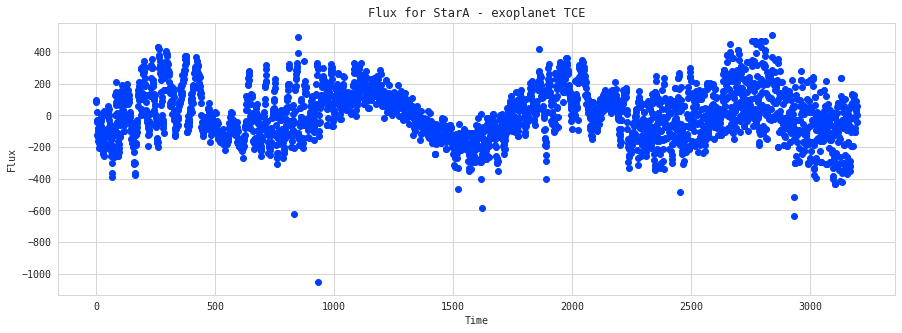

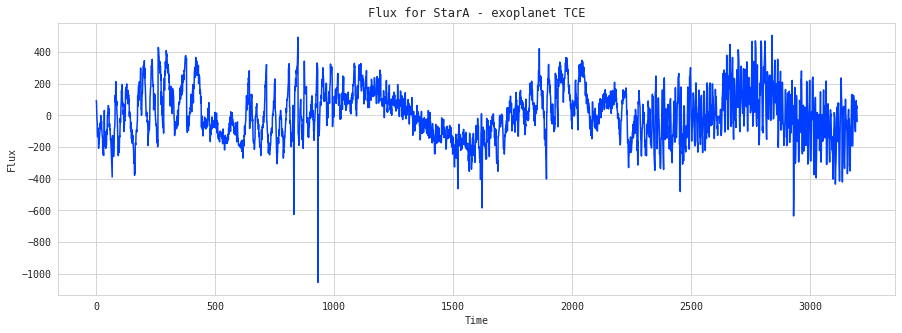

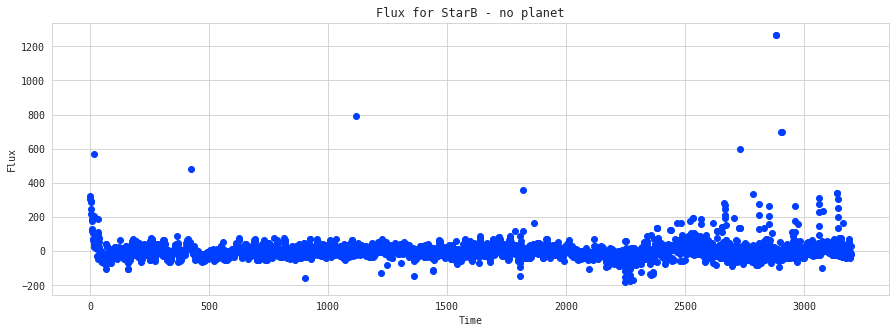

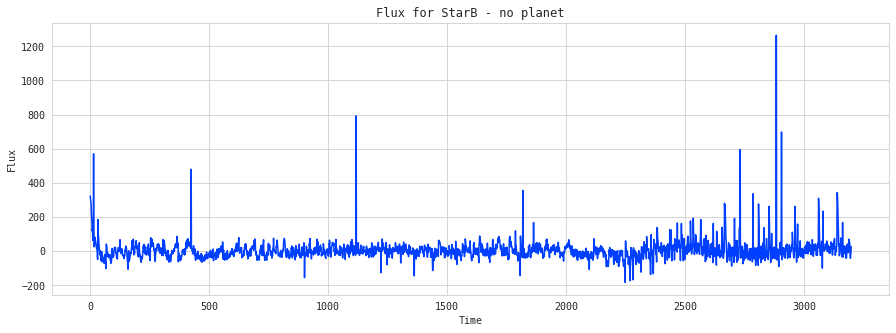

In [13]:
# Scatter Plot For First Star
plt.figure(figsize=(15, 5))
plt.scatter(pd.Series([i for i in range(1, len(starA))]), starA[1:])
plt.ylabel('Flux')
plt.xlabel('Time')
plt.title('Flux for StarA - exoplanet TCE')
plt.show()

# Line Plot For First Star
plt.figure(figsize=(15, 5))
plt.plot(pd.Series([i for i in range(1, len(starA))]), starA[1:])
plt.ylabel('Flux')
plt.xlabel('Time')
plt.title('Flux for StarA - exoplanet TCE')
plt.show()


# Scatter Plot For Last Star
plt.figure(figsize=(15, 5))
plt.scatter(pd.Series([i for i in range(1, len(starB))]), starB[1:])
plt.ylabel('Flux')
plt.xlabel('Time')
plt.title('Flux for StarB - no planet')
plt.show()

# Line Plot For last Star
plt.figure(figsize=(15, 5))
plt.plot(pd.Series([i for i in range(1, len(starB))]), starB[1:])
plt.ylabel('Flux')
plt.xlabel('Time')
plt.title('Flux for StarB - no planet')
plt.show()


# Model 1 - Keras Neural Network

In [24]:
# import additional libraries from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.ndimage.filters import uniform_filter1d
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import random

In [26]:
!pip install keras
# !pip install tensorflow

In [27]:
# import additional libraries for keras
from keras.utils.np_utils import to_categorical

from keras.preprocessing.text import Tokenizer
from keras import models, layers, optimizers


from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPool1D, Dense, Dropout, Flatten, \
BatchNormalization, Input, concatenate, Activation
from keras.optimizers import Adam

ModuleNotFoundError: No module named 'keras'

## Train-Test Split

In [25]:
# Prep data for ML : Separate target and feature datasets
# TARGETS
y_train = train['LABEL']
y_test = test['LABEL']

# FEATURES
x_train = train.drop(columns=['LABEL'], axis=1)
x_test = test.drop(columns=['LABEL'], axis=1)


In [27]:
x_train = np.array(x_train)

In [28]:
x_train = ((x_train - np.mean(x_train, axis=1).reshape(-1,1)) / 
            np.std(x_train, axis=1).reshape(-1,1))

In [29]:
x_test = np.array(x_test)

In [30]:
x_test = ((x_test - np.mean(x_test, axis=1).reshape(-1,1)) / 
          np.std(x_test, axis=1).reshape(-1,1))

In [31]:

x_train = np.stack([x_train, uniform_filter1d(x_train, axis=1, size=200)], axis=2)
x_test = np.stack([x_test, uniform_filter1d(x_test, axis=1, size=200)], axis=2)

## Train Model

In [32]:
model = Sequential()
model.add(Conv1D(filters=8, kernel_size=11, activation='relu', 
                 input_shape=x_train.shape[1:]))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=16, kernel_size=11, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=32, kernel_size=11, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

NameError: name 'Sequential' is not defined

In [41]:
# As we saw earlier, the data here is extremely unbalanced, with only a few 
# positive examples. To correct for this, we'll use the positive examples more often, 
# so that the net sees 50% of each over each batch. 

def batch_generator(x_train, y_train, batch_size=32):
    """
    Gives equal number of positive and negative samples, and rotates them randomly 
    in time
    """
    half_batch = batch_size // 2
    x_batch = np.empty((batch_size, x_train.shape[1], x_train.shape[2]), dtype='float32')
    y_batch = np.empty((batch_size, y_train.shape[1]), dtype='float32')
    
    yes_idx = np.where(y_train[:,0] == 1.)[0]
    non_idx = np.where(y_train[:,0] == 0.)[0]
    
    while True:
        np.random.shuffle(yes_idx)
        np.random.shuffle(non_idx)
    
        x_batch[:half_batch] = x_train[yes_idx[:half_batch]]
        x_batch[half_batch:] = x_train[non_idx[half_batch:batch_size]]
        y_batch[:half_batch] = y_train[yes_idx[:half_batch]]
        y_batch[half_batch:] = y_train[non_idx[half_batch:batch_size]]
    
        for i in range(batch_size):
            sz = np.random.randint(x_batch.shape[1])
            x_batch[i] = np.roll(x_batch[i], sz, axis = 0)
     
        yield x_batch, y_batch

In [42]:
#Start with a slightly lower learning rate, to ensure convergence
model.compile(optimizer=Adam(1e-5), loss = 'binary_crossentropy', metrics=['accuracy'])
hist = model.fit_generator(batch_generator(x_train, y_train, 32), 
                           validation_data=(x_test, y_test), 
                           verbose=0, epochs=5,
                           steps_per_epoch=x_train.shape[1]//32)

NameError: name 'model' is not defined

In [43]:
# speeding things up
model.compile(optimizer=Adam(4e-5), loss = 'binary_crossentropy', metrics=['accuracy'])
hist = model.fit_generator(batch_generator(x_train, y_train, 32), 
                           validation_data=(x_test, y_test), 
                           verbose=2, epochs=40,
                           steps_per_epoch=x_train.shape[1]//32)

NameError: name 'model' is not defined

In [139]:
# Look at convergence
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['accuracy'], color='b')
plt.plot(hist.history['val_accuracy'], color='r')
plt.show()

NameError: name 'hist' is not defined

In [ ]:
non_idx = np.where(y_test[:,0] == 0.)[0]
yes_idx = np.where(y_test[:,0] == 1.)[0]
y_hat = model.predict(x_test)[:,0]

In [ ]:
plt.plot([y_hat[i] for i in yes_idx], 'bo')
plt.show()
plt.plot([y_hat[i] for i in non_idx], 'ro')
plt.show()

These graphs show that while not all five positive examples all get 0.95-1.00 score, almost all negative examples get score close to zero with a few exceptions.

## Validation

In [44]:
# For classification we'll choose an optimal cutoff score with the help of Sklearn
y_true = (y_test[:, 0] + 0.5).astype("int")
fpr, tpr, thresholds = roc_curve(y_true, y_hat)
plt.plot(thresholds, 1.-fpr)
plt.plot(thresholds, tpr)
plt.show()
crossover_index = np.min(np.where(1.-fpr <= tpr))
crossover_cutoff = thresholds[crossover_index]
crossover_specificity = 1.-fpr[crossover_index]
print("Crossover at {0:.2f} with specificity {1:.2f}".format(crossover_cutoff, crossover_specificity))
plt.plot(fpr, tpr)
plt.show()
print("ROC area under curve is {0:.2f}".format(roc_auc_score(y_true, y_hat)))

ValueError: Can only tuple-index with a MultiIndex

In [ ]:
false_positives = np.where(y_hat * (1. - y_test) > 0.5)[0]
for i in non_idx:
    if y_hat[i] > crossover_cutoff:
        print(i)
        plt.plot(x_test[i])
        plt.show()

# Conclusion - Part I

Above, we were able to identify with 99% accuracy the handful of stars that have an exoplanet orbiting around them. 

# Next

In the next section of the project, we'll take another approach to detecting exoplanets using computer vision. Please go to the notebook `[starskøpe-2]` to see how I use a Restricted Boltzmann Machines neural network model to classify stars as exoplanet hosts using spectograph images of the flux values to find transiting exoplanets. 
